# Modeling
Group 1

Kyle Anderson

# Table of Contents


1. [Modeling](#modeling)
    - [Package Import](#package_import)
    - [Data Loading](#data_loading)
    - [Data Dictionary](#basic_stats)
2. [Tracking the Life of Equipment](#tracking_the_life_of_equipment)
    - [Match ID and Dates](#match_id_and_dates)
    - [Subtract Start Dates and Maintenance Date of Equipment ID](#subtract_start_dates_and_maintenance_date_of_equipment_id)
3. [Pre-Processing for Modeling](#pre_processing_for_modeling)
4. [Predictions of Maintenance Date](#predictions_of_maintenance_date)
    - [Plot the Metrics](#plot_the_metrics)
    - [Stats per Equipment](#stats_per_equipment)
    - [Model by Location](#model_by_location)
    - [Data Cleaning](#data_cleaning)
    - [Alternate Modeling](#alternate_modeling)
5. [Start Ups](#start_ups)
    - [Breakdown List](#breakdown_list)
    - [Equipment List](#equipment_list)
6. [Predicting Minutes of Maintenance](#predicting_minutes_of_maintenance)


## Package Import

In [21]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import os
from io import StringIO
import json
import warnings
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error


warnings.filterwarnings('ignore', category=DeprecationWarning)


In [22]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

<a class="anchor" id="data_loading"></a>

## Data Loading

[Back to Table of Contents](#back_to_toc)

In [23]:
iwc_data = fr"C:\Users\kyle.anderson\pythonProject\msbaCapstone\Capstone\Capstone 3\IWC_Work_Orders_Extract.csv"
df = pd.read_csv(iwc_data, low_memory=False)
df.head()

,ORDER_ID,PLANT_ID,PRODUCTION_LOCATION,EXECUTION_START_DATE,EXECUTION_FINISH_DATE,ACTUAL_START_TIME,ACTUAL_FINISH_TIME,ACTUAL_WORK_IN_MINUTES,MAINTENANCE_PLAN,MAINTENANCE_ITEM,MAINTENANCE_ACTIVITY_TYPE,ORDER_DESCRIPTION,MAINTENANCE_TYPE_DESCRIPTION,FUNCTIONAL_LOC,FUNCTIONAL_AREA_NODE_1_MODIFIED,FUNCTIONAL_AREA_NODE_2_MODIFIED,FUNCTIONAL_AREA_NODE_3_MODIFIED,FUNCTIONAL_AREA_NODE_4_MODIFIED,FUNCTIONAL_AREA_NODE_5_MODIFIED,EQUIPMENT_ID,EQUIPMENT_DESC,EQUIP_CAT_DESC,EQUIP_START_UP_DATE,EQUIP_VALID_FROM,EQUIP_VALID_TO
0,705642457,G812,ROMA,2024-05-04,2024-05-12,06:00:00.000,23:04:08.000,390.0,NaN,NaN,Unplanned,L2 GEARBOX LEAK (SEE ATTACHED),Corrective Maintenance Order,G812-PRD-L15-L03-L030-020,PRODUCTION,G812 PRD FILLER_ROTARY_CAN,G812 PRD FILLER_ROTARY_CAN LINE 3,CONVEYOR,FULL CAN CONVEYOR,300126812.0,FULL CAN CONVEYOR (FC41B),Machines,2020-04-22,2020-02-10,9999-12-31
1,704191697,G812,ROMA,2022-09-13,2022-09-13,06:00:00.000,17:17:24.000,420.0,NaN,NaN,Unplanned,LINE 3 CONVEYOR AT CAN CODER,Corrective Maintenance Order,G812-PRD-L15-L03-L030-020,PRODUCTION,G812 PRD FILLER_ROTARY_CAN,G812 PRD FILLER_ROTARY_CAN LINE 3,CONVEYOR,FULL CAN CONVEYOR,300126812.0,FULL CAN CONVEYOR (FC41B),Machines,2020-04-22,2020-02-10,9999-12-31
2,704466547,G812,ROMA,2022-12-21,2022-12-21,07:00:00.000,07:00:00.000,30.0,NaN,NaN,Unplanned,BROKEN CONVEYOR RAIL,Corrective Maintenance Order,G812-PRD-L15-L03-L030-020,PRODUCTION,G812 PRD FILLER_ROTARY_CAN,G812 PRD FILLER_ROTARY_CAN LINE 3,CONVEYOR,FULL CAN CONVEYOR,300126812.0,FULL CAN CONVEYOR (FC41B),Machines,2020-04-22,2020-02-10,9999-12-31
3,703834477,G812,ROMA,2022-07-04,2022-07-04,06:00:00.000,06:00:00.000,60.0,NaN,NaN,Unplanned,LINE 3 CONVEYOR,Corrective Maintenance Order,G812-PRD-L15-L03-L030-020,PRODUCTION,G812 PRD FILLER_ROTARY_CAN,G812 PRD FILLER_ROTARY_CAN LINE 3,CONVEYOR,FULL CAN CONVEYOR,300126812.0,FULL CAN CONVEYOR (FC41B),Machines,2020-04-22,2020-02-10,9999-12-31
4,704661125,G291,MONZA,2023-03-15,2023-03-15,07:00:00.000,07:00:00.000,120.0,NaN,NaN,Unplanned,REPLACED SONIC AIR BLOWER BELT,Corrective Maintenance Order,G291-PRD-P05,MONZA PRODUCTION,AIR SYSTEMS,NaN,NaN,NaN,300001088.0,TANK_STL_STOR_AIR,Machines,2017-02-15,2023-12-11,9999-12-31


<a class="anchor" id="basic_stats"></a>

### Data Dictionary

* Order ID - is the most unique and uninteresting
* Plant ID - 6 locations, Top is G261
* Production Location - 6 locations, Silverstone at the top
* Execution Start Date - Mean is 2020-12-20, it would be good to run a graph or median to see weights and maybe reduce for data cleaning
* Execution Finish Date - Mean is 2020-12-21, more stats needed
* Actual Start Time - Most frequent is 12 am...
* Actual Finish Time - Most frequent is 12 am...
* Actual Work In Minutes - tbd
* Maintenance Plan - tbd
* Maintenance Item - tbd
* Maintenance Activity Type - Unplanned most common, TARGET variable
* Order Description - Dtrine most common
* Maintenance Type Description - Preventive Maintenance Order most common
* Functional Loc - G812-PRD most common with 667 unique locations
* Functional Area Node 1 Modified - COTA Production most common, 7 unique and this is where I identified, whoever created this is a motorcycle racing fan
* Functional Area Node 2 Modified - CAN Line most common with 67 unique
* Functional Area Node 3 Modified - Line #4- Filler Rotary CAN most common, 141 unique
* Functional Area Node 4 Modified - Filler most common, 86 unique
* Functional Area Node 5 Modified - Full CAN to Accumulation Table most common, 36 unique
* Equipment Desc - L1 Filler Rotary CAN 72 Valve, 807 unique
* Equip Cat Desc - 4 unique, top Machines
* Equip Start Up Date - 2017-06-19 mean, more detail needed
* Equip Valid From - 137 unique, top is 2017-02-15
* Equip Valid To - 1 unique, assumption is all pieces last to the end of time?

### Tracking the life of Equipment ID

Prep of a data frame with unique values to track life cycle of an EQUIPMENT_ID

In [24]:
df2 = df.copy()
print(f"{len(df2['EQUIPMENT_ID']):_}")

# Drop NaN

# Keep rows where 'Functional_area_node_2' is not NaN even if 'EQUIPMENT_ID' is NaN
df2 = df2[~df2['FUNCTIONAL_AREA_NODE_2_MODIFIED'].isna() | ~df2['EQUIPMENT_ID'].isna()]
# Drop rows where both 'EQUIPMENT_ID' and 'Functional_area_node_2' are NaN
df2 = df2.dropna(subset=['EQUIPMENT_ID', 'FUNCTIONAL_AREA_NODE_2_MODIFIED'], how='all')

# Concat for unique life cycles
df2['Life_ID'] = df2['EQUIPMENT_ID'].astype(str) + ' ' + df2['PRODUCTION_LOCATION'] + ' '  + df2['ACTUAL_START_TIME'].astype(str) + df2['EXECUTION_START_DATE'].astype(str)
df2 = df2[['Life_ID','EQUIPMENT_ID','PRODUCTION_LOCATION','ACTUAL_START_TIME','EXECUTION_START_DATE','ACTUAL_WORK_IN_MINUTES','MAINTENANCE_ACTIVITY_TYPE','FUNCTIONAL_AREA_NODE_2_MODIFIED','FUNCTIONAL_AREA_NODE_3_MODIFIED','EQUIPMENT_DESC']].sort_values(by=['EQUIPMENT_ID','EXECUTION_START_DATE'], ascending=True)

print(f"{len(df2['EQUIPMENT_ID']):_}")
df2.head()

1_427_264
291_795


,Life_ID,EQUIPMENT_ID,PRODUCTION_LOCATION,ACTUAL_START_TIME,EXECUTION_START_DATE,ACTUAL_WORK_IN_MINUTES,MAINTENANCE_ACTIVITY_TYPE,FUNCTIONAL_AREA_NODE_2_MODIFIED,FUNCTIONAL_AREA_NODE_3_MODIFIED,EQUIPMENT_DESC
224341,200087110.0 COTA 06:00:00.0002021-03-30,200087110.0,COTA,06:00:00.000,2021-03-30,6.0,Unplanned,FLEET FUNCTIONAL AREAS,WAREHOUSE,NaN
1021363,200108112.0 ROMA 06:00:00.0002020-05-30,200108112.0,ROMA,06:00:00.000,2020-05-30,180.0,Unplanned,FLEET FUNCTIONAL AREAS,WAREHOUSE,NaN
449320,200108112.0 ROMA 06:00:00.0002020-08-04,200108112.0,ROMA,06:00:00.000,2020-08-04,120.0,Unplanned,FLEET FUNCTIONAL AREAS,WAREHOUSE,NaN
712483,200108112.0 ROMA 06:00:00.0002020-09-21,200108112.0,ROMA,06:00:00.000,2020-09-21,60.0,Unplanned,FLEET FUNCTIONAL AREAS,WAREHOUSE,NaN
844336,200108112.0 ROMA 07:00:00.0002020-12-09,200108112.0,ROMA,07:00:00.000,2020-12-09,60.0,Unplanned,FLEET FUNCTIONAL AREAS,WAREHOUSE,NaN


Cut the maintenance count from 1.4m to 291k

## Match ID and Dates

In [25]:
df2['ID'] = df2['Life_ID'].str.extract(r'(\d+\.\d+)')[0]
df2.reset_index(drop=True, inplace=True)
df2['EXECUTION_START_DATE'] = pd.to_datetime(df2['EXECUTION_START_DATE'])
df2.head()

,Life_ID,EQUIPMENT_ID,PRODUCTION_LOCATION,ACTUAL_START_TIME,EXECUTION_START_DATE,ACTUAL_WORK_IN_MINUTES,MAINTENANCE_ACTIVITY_TYPE,FUNCTIONAL_AREA_NODE_2_MODIFIED,FUNCTIONAL_AREA_NODE_3_MODIFIED,EQUIPMENT_DESC,ID
0,200087110.0 COTA 06:00:00.0002021-03-30,200087110.0,COTA,06:00:00.000,2021-03-30,6.0,Unplanned,FLEET FUNCTIONAL AREAS,WAREHOUSE,NaN,200087110.0
1,200108112.0 ROMA 06:00:00.0002020-05-30,200108112.0,ROMA,06:00:00.000,2020-05-30,180.0,Unplanned,FLEET FUNCTIONAL AREAS,WAREHOUSE,NaN,200108112.0
2,200108112.0 ROMA 06:00:00.0002020-08-04,200108112.0,ROMA,06:00:00.000,2020-08-04,120.0,Unplanned,FLEET FUNCTIONAL AREAS,WAREHOUSE,NaN,200108112.0
3,200108112.0 ROMA 06:00:00.0002020-09-21,200108112.0,ROMA,06:00:00.000,2020-09-21,60.0,Unplanned,FLEET FUNCTIONAL AREAS,WAREHOUSE,NaN,200108112.0
4,200108112.0 ROMA 07:00:00.0002020-12-09,200108112.0,ROMA,07:00:00.000,2020-12-09,60.0,Unplanned,FLEET FUNCTIONAL AREAS,WAREHOUSE,NaN,200108112.0


## Subtract Start dates and maintenance date of Equipment_ID

In [26]:
# Create a function to get the maintenance date of equipment
def calculate_date_difference(df2):
    df['Date_Diff'] = None 
    for i in range(1, len(df2)):
        if df2.loc[i, 'ID'][:2] == df2.loc[i-1, 'ID'][:2]:
            df2.loc[i, 'Date_Diff'] = (df2.loc[i, 'EXECUTION_START_DATE'] - df2.loc[i-1, 'EXECUTION_START_DATE']).days
    return df2

df2 = calculate_date_difference(df2)



average_date_diff = df2.groupby('EQUIPMENT_ID')['Date_Diff'].mean().reset_index()
average_date_diff.rename(columns={'Date_Diff': 'Average_Date_Diff'}, inplace=True)

df2 = df2.merge(average_date_diff, on='EQUIPMENT_ID', how='left')


def set_date_diff(row):
    if row['Date_Diff'] < 0:
        if row['Average_Date_Diff'] < 0:
            return 0
        else:
            return row['Average_Date_Diff']
    return row['Date_Diff']

df2['Date_Diff'] = df2.apply(set_date_diff, axis=1)

df2.drop(columns=['Average_Date_Diff'], inplace=True)

df2[['EQUIPMENT_ID', 'Date_Diff']].head()


,EQUIPMENT_ID,Date_Diff
0,200087110.0,NaN
1,200108112.0,17.6
2,200108112.0,66.0
3,200108112.0,48.0
4,200108112.0,79.0


In [27]:
df2.head(10)

,Life_ID,EQUIPMENT_ID,PRODUCTION_LOCATION,ACTUAL_START_TIME,EXECUTION_START_DATE,ACTUAL_WORK_IN_MINUTES,MAINTENANCE_ACTIVITY_TYPE,FUNCTIONAL_AREA_NODE_2_MODIFIED,FUNCTIONAL_AREA_NODE_3_MODIFIED,EQUIPMENT_DESC,ID,Date_Diff
0,200087110.0 COTA 06:00:00.0002021-03-30,200087110.0,COTA,06:00:00.000,2021-03-30,6.0,Unplanned,FLEET FUNCTIONAL AREAS,WAREHOUSE,NaN,200087110.0,NaN
1,200108112.0 ROMA 06:00:00.0002020-05-30,200108112.0,ROMA,06:00:00.000,2020-05-30,180.0,Unplanned,FLEET FUNCTIONAL AREAS,WAREHOUSE,NaN,200108112.0,17.600000
2,200108112.0 ROMA 06:00:00.0002020-08-04,200108112.0,ROMA,06:00:00.000,2020-08-04,120.0,Unplanned,FLEET FUNCTIONAL AREAS,WAREHOUSE,NaN,200108112.0,66.000000
3,200108112.0 ROMA 06:00:00.0002020-09-21,200108112.0,ROMA,06:00:00.000,2020-09-21,60.0,Unplanned,FLEET FUNCTIONAL AREAS,WAREHOUSE,NaN,200108112.0,48.000000
4,200108112.0 ROMA 07:00:00.0002020-12-09,200108112.0,ROMA,07:00:00.000,2020-12-09,60.0,Unplanned,FLEET FUNCTIONAL AREAS,WAREHOUSE,NaN,200108112.0,79.000000
5,200108112.0 ROMA 06:00:00.0002021-06-26,200108112.0,ROMA,06:00:00.000,2021-06-26,90.0,Unplanned,FLEET FUNCTIONAL AREAS,WAREHOUSE,NaN,200108112.0,199.000000
6,200108117.0 ROMA 06:00:00.0002020-05-29,200108117.0,ROMA,06:00:00.000,2020-05-29,120.0,Unplanned,FLEET FUNCTIONAL AREAS,WAREHOUSE,NaN,200108117.0,0.333333
7,200108117.0 ROMA 07:00:00.0002020-11-03,200108117.0,ROMA,07:00:00.000,2020-11-03,60.0,Unplanned,FLEET FUNCTIONAL AREAS,WAREHOUSE,NaN,200108117.0,158.000000
8,200108117.0 ROMA 06:00:00.0002021-06-27,200108117.0,ROMA,06:00:00.000,2021-06-27,120.0,Unplanned,FLEET FUNCTIONAL AREAS,WAREHOUSE,NaN,200108117.0,236.000000
9,200108119.0 ROMA 06:00:00.0002020-07-15,200108119.0,ROMA,06:00:00.000,2020-07-15,120.0,Unplanned,FLEET FUNCTIONAL AREAS,WAREHOUSE,NaN,200108119.0,0.000000


### Pre-Processing for Modeling

In [28]:
warnings.filterwarnings('ignore', category=DeprecationWarning)
from sklearn.preprocessing import LabelEncoder
df_encoded = df2.copy()

le = LabelEncoder()
df_encoded['EQUIPMENT_DESC_encoded'] = le.fit_transform(df2['EQUIPMENT_DESC'])
df_encoded['MAINTENANCE_ACTIVITY_TYPE'] = le.fit_transform(df2['MAINTENANCE_ACTIVITY_TYPE'])
df_encoded['PRODUCTION_LOCATION_encoded'] = le.fit_transform(df2['PRODUCTION_LOCATION'])
df_encoded['FUNCTIONAL_AREA_NODE_2_MODIFIED_encoded'] = le.fit_transform(df2['FUNCTIONAL_AREA_NODE_2_MODIFIED'])
df_encoded['FUNCTIONAL_AREA_NODE_3_MODIFIED_encoded'] = le.fit_transform(df2['FUNCTIONAL_AREA_NODE_3_MODIFIED'])

df_encoded['ACTUAL_START_TIME'] = pd.to_datetime(df_encoded['ACTUAL_START_TIME'], errors='coerce')
df_encoded['EXECUTION_START_DATE'] = pd.to_datetime(df_encoded['EXECUTION_START_DATE'], errors='coerce')

# Extract hour and day features or time differences if needed
df_encoded['start_hour'] = df_encoded['ACTUAL_START_TIME'].dt.hour
df_encoded['execution_hour'] = df_encoded['EXECUTION_START_DATE'].dt.hour
df_encoded['execution_day'] = df_encoded['EXECUTION_START_DATE'].dt.day

df_encoded.head()
# Display the resulting DataFrame
# df2[['Life_ID', 'Date_Diff','EQUIPMENT_ID','PRODUCTION_LOCATION','FUNCTIONAL_AREA_NODE_2_MODIFIED','EQUIPMENT_DESC','MAINTENANCE_ACTIVITY_TYPE','ACTUAL_WORK_IN_MINUTES','EXECUTION_START_DATE']].head()

,Life_ID,EQUIPMENT_ID,PRODUCTION_LOCATION,ACTUAL_START_TIME,EXECUTION_START_DATE,ACTUAL_WORK_IN_MINUTES,MAINTENANCE_ACTIVITY_TYPE,FUNCTIONAL_AREA_NODE_2_MODIFIED,FUNCTIONAL_AREA_NODE_3_MODIFIED,EQUIPMENT_DESC,ID,Date_Diff,EQUIPMENT_DESC_encoded,PRODUCTION_LOCATION_encoded,FUNCTIONAL_AREA_NODE_2_MODIFIED_encoded,FUNCTIONAL_AREA_NODE_3_MODIFIED_encoded,start_hour,execution_hour,execution_day
0,200087110.0 COTA 06:00:00.0002021-03-30,200087110.0,COTA,2024-12-08 06:00:00,2021-03-30,6.0,1,FLEET FUNCTIONAL AREAS,WAREHOUSE,NaN,200087110.0,NaN,807,0,14,137,6,0,30
1,200108112.0 ROMA 06:00:00.0002020-05-30,200108112.0,ROMA,2024-12-08 06:00:00,2020-05-30,180.0,1,FLEET FUNCTIONAL AREAS,WAREHOUSE,NaN,200108112.0,17.6,807,3,14,137,6,0,30
2,200108112.0 ROMA 06:00:00.0002020-08-04,200108112.0,ROMA,2024-12-08 06:00:00,2020-08-04,120.0,1,FLEET FUNCTIONAL AREAS,WAREHOUSE,NaN,200108112.0,66.0,807,3,14,137,6,0,4
3,200108112.0 ROMA 06:00:00.0002020-09-21,200108112.0,ROMA,2024-12-08 06:00:00,2020-09-21,60.0,1,FLEET FUNCTIONAL AREAS,WAREHOUSE,NaN,200108112.0,48.0,807,3,14,137,6,0,21
4,200108112.0 ROMA 07:00:00.0002020-12-09,200108112.0,ROMA,2024-12-08 07:00:00,2020-12-09,60.0,1,FLEET FUNCTIONAL AREAS,WAREHOUSE,NaN,200108112.0,79.0,807,3,14,137,7,0,9


Pre-processing helps to organize the data for later examination by time and counts of variables

## Predictions of Maintenance Date

Target Variable
* Date_Diff is the lifespan of the equipment

In [29]:
warnings.filterwarnings('ignore')

# Loop through each unique production location
for location in df_encoded['PRODUCTION_LOCATION'].unique():
    # Filter the DataFrame for the current location
    df_location = df_encoded[df_encoded['PRODUCTION_LOCATION'] == location]
    # Filter equipment IDs with a count of at least 100
    equipment_counts = df_location['EQUIPMENT_ID'].value_counts()
    equipment_ids_to_keep = equipment_counts[equipment_counts >= 200].index
    df_location = df_location[df_location['EQUIPMENT_ID'].isin(equipment_ids_to_keep)]

    # Convert any time columns to datetime format and extract hour if needed
    df_location['ACTUAL_START_TIME'] = pd.to_datetime(df_location['ACTUAL_START_TIME'], errors='coerce')
    df_location['EXECUTION_START_DATE'] = pd.to_datetime(df_location['EXECUTION_START_DATE'], errors='coerce')
    df_location['start_hour'] = df_location['ACTUAL_START_TIME'].dt.hour
    df_location['execution_hour'] = df_location['EXECUTION_START_DATE'].dt.hour
    df_location['execution_day'] = df_location['EXECUTION_START_DATE'].dt.day
    df_location.drop(columns=['ACTUAL_START_TIME', 'EXECUTION_START_DATE'], inplace=True)

    # NA's or negatives in date_diff
    average_date_diff = df_encoded.groupby('EQUIPMENT_ID')['Date_Diff'].mean().reset_index()
    average_date_diff.rename(columns={'Date_Diff': 'Average_Date_Diff'}, inplace=True)
    df_encoded = df_encoded.merge(average_date_diff, on='EQUIPMENT_ID', how='left')
    def set_date_diff(row):
        if row['Date_Diff'] < 0:
            if row['Average_Date_Diff'] < 0:
                return 1
            else:
                return row['Average_Date_Diff']
        return row['Date_Diff']
    df_encoded['Date_Diff'] = df_encoded.apply(set_date_diff, axis=1)
    df_encoded.drop(columns=['Average_Date_Diff'], inplace=True)


    # Features and target variable
    X = df_location[['EQUIPMENT_ID', 'start_hour', 'execution_hour','execution_day', 'ACTUAL_WORK_IN_MINUTES',
                     'ID', 'EQUIPMENT_DESC_encoded', 'PRODUCTION_LOCATION_encoded',
                     'FUNCTIONAL_AREA_NODE_2_MODIFIED_encoded','FUNCTIONAL_AREA_NODE_3_MODIFIED_encoded','MAINTENANCE_ACTIVITY_TYPE',]]
    y = df_location['Date_Diff']

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=99)

    # Train model
    model = RandomForestRegressor(min_samples_leaf=3, min_samples_split=2,max_depth=8, n_estimators=200, random_state=46)
    model.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)

    print(f"Location: {location}")
    print("MAE (Days +-):", round(mae, 2))
    print("RMSE:", rmse)
    print("R2:", r2)
    
    print()

    # Predict on the entire dataset for this location
   # df_location['Predicted_Date_Diff'] = model.predict(X)

Location: COTA
MAE (Days +-): 3.47
RMSE: 6.577260407338923
R2: 0.13541004115955824

Location: ROMA
MAE (Days +-): 2.25
RMSE: 5.58426907986662
R2: 0.010463589390284134

Location: MONZA
MAE (Days +-): 3.75
RMSE: 7.196754716522867
R2: 0.18678322162821415

Location: SUZUKA
MAE (Days +-): 3.85
RMSE: 12.365905775393164
R2: -0.025851573447950305

Location: SILVERSTONE
MAE (Days +-): 4.35
RMSE: 8.737766589073926
R2: 0.12315916050390241

Location: MONACO
MAE (Days +-): 4.22
RMSE: 10.833204622966118
R2: -0.0516432917613614



The metrics came in under 7 days which is great!

## Plot the Metrics

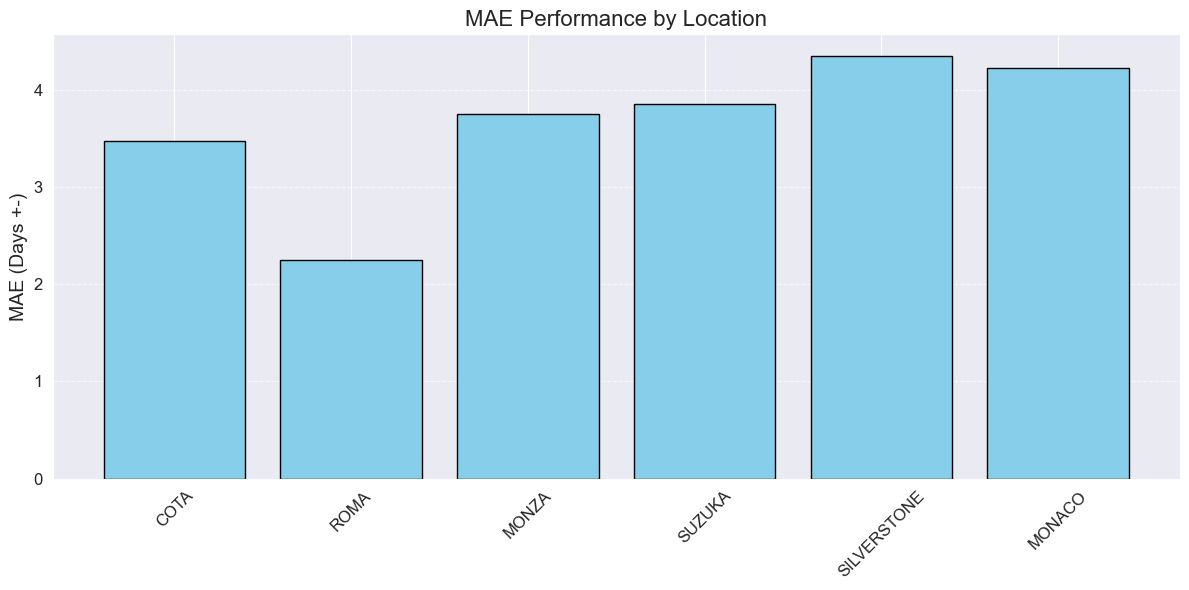

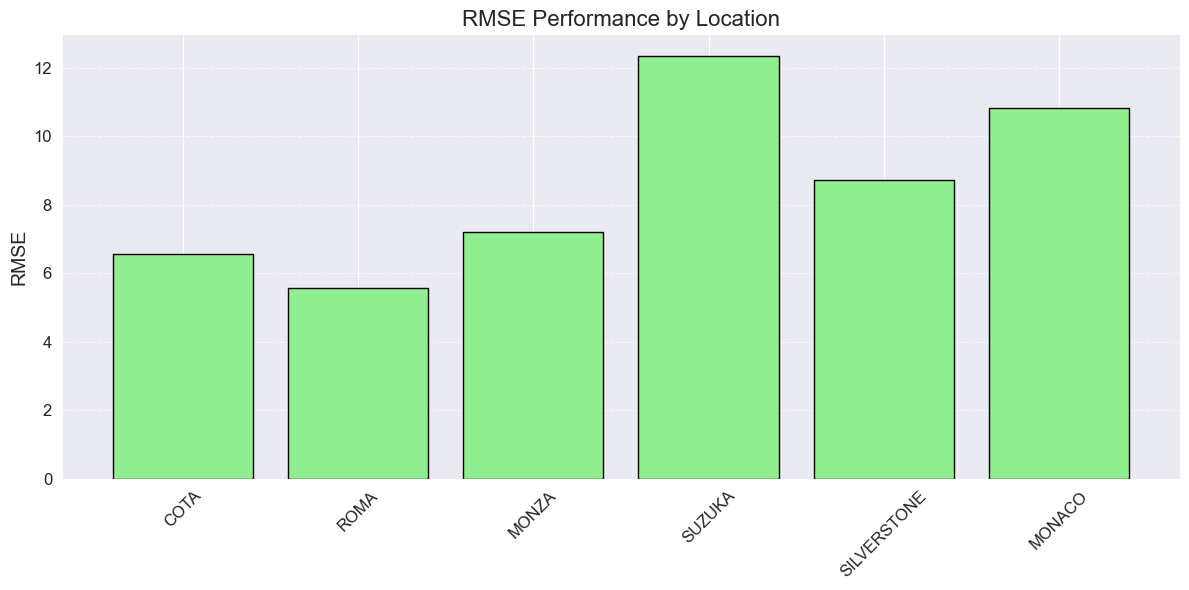

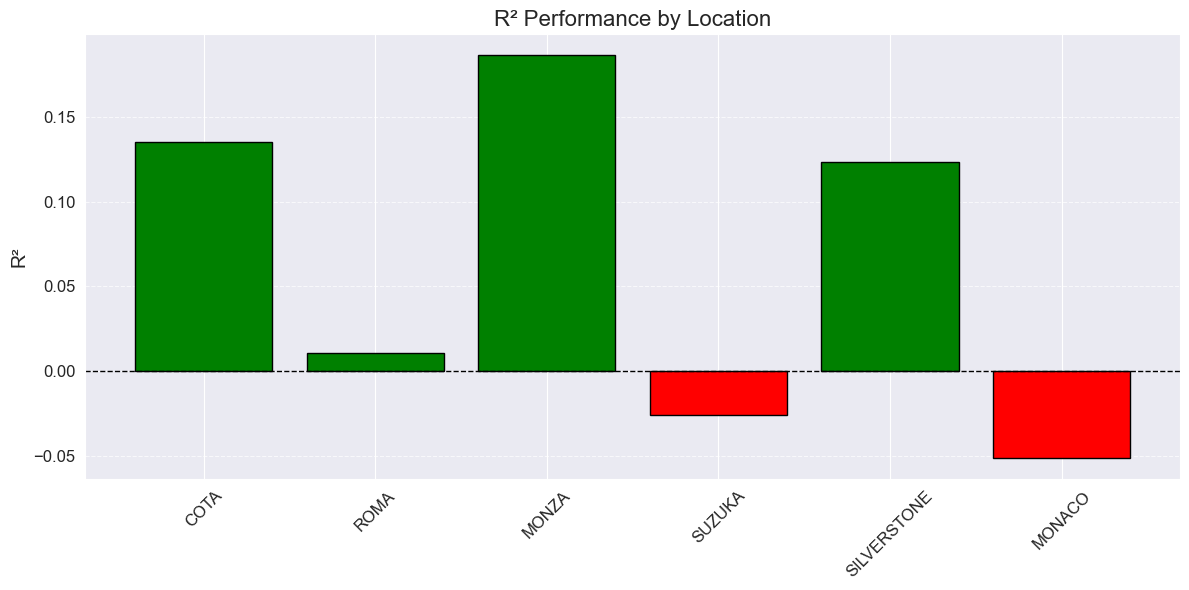

In [30]:
locations = ["COTA", "ROMA", "MONZA", "SUZUKA", "SILVERSTONE", "MONACO"]
mae_values = [3.47, 2.25, 3.75, 3.85, 4.35, 4.22]
rmse_values = [6.577260407338923, 5.58426907986662, 7.196754716522867, 12.365905775393164, 8.737766589073926, 10.833204622966118]
r2_values = [0.13541004115955824, 0.010463589390284134, 0.18678322162821415, -0.025851573447950305, 0.12315916050390241, -0.0516432917613614]

plt.figure(figsize=(12, 6))
plt.bar(locations, mae_values, color='skyblue', edgecolor='black')
plt.title("MAE Performance by Location", fontsize=16)
plt.xlabel("", fontsize=14)
plt.ylabel("MAE (Days +-)", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# RMSE
plt.figure(figsize=(12, 6))
plt.bar(locations, rmse_values, color='lightgreen', edgecolor='black')
plt.title("RMSE Performance by Location", fontsize=16)
plt.xlabel("", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# R²
plt.figure(figsize=(12, 6))
colors = ["green" if r2 > 0 else "red" for r2 in r2_values]
plt.bar(locations, r2_values, color=colors, edgecolor='black')
plt.axhline(0, color='black', linewidth=1, linestyle='--')
plt.title("R² Performance by Location", fontsize=16)
plt.xlabel("", fontsize=14)
plt.ylabel("R²", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Investigate more items when it comes to equipment and time series prediction

## Stats per equipment

In [31]:
# Getting descriptive statistics for both time difference columns
stats_per_equipment = df2.groupby('EQUIPMENT_ID')['Date_Diff'].describe()
stats_per_equipment.head()

,count,mean,std,min,25%,50%,75%,max
EQUIPMENT_ID,,,,,,,,
200087110.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
200108112.0,5.0,81.920000,69.385388,17.600000,48.000000,66.0,79.00,199.0
200108117.0,3.0,131.444444,120.056622,0.333333,79.166667,158.0,197.00,236.0
200108119.0,4.0,69.750000,73.920565,0.000000,27.750000,53.5,95.50,172.0
200108120.0,4.0,60.937500,34.718136,16.750000,41.687500,67.5,86.75,92.0


## Model by Location

Include maintenance optimization to do multiple maintenance jobs if their expectancy hits in the same week

Model using date_diff as a feature and predict planned or unplanned maintenance


## Data Cleaning

In [32]:
# ensuring consistent date/time format
df['START_YEAR_MONTH'] = pd.to_datetime(df['EXECUTION_START_DATE']).dt.strftime('%Y-%m')
# creating new year and equiment start up year/month columns
df['YEAR'] = pd.to_datetime(df['EXECUTION_START_DATE']).dt.year
df['EQUIP_START_UP_YEAR_MONTH'] = pd.to_datetime(df['EQUIP_START_UP_DATE']).dt.strftime('%Y-%m')
df['ACTUAL_START_TIME'] = pd.to_datetime('1900-01-01 ' + df['ACTUAL_START_TIME'], errors='coerce')
df['ACTUAL_FINISH_TIME'] = pd.to_datetime('1900-01-01 ' + df['ACTUAL_FINISH_TIME'], errors='coerce')

date_columns = [col for col in df.columns if 'date' in col.lower()]
df[date_columns] = df[date_columns].apply(pd.to_datetime, errors='coerce')
# extracting the year-month from 'EXECUTION_START_DATE'
df['MONTH'] = df['EXECUTION_START_DATE'].dt.to_period('M').dt.to_timestamp()

## Alternate Modeling

### Start Ups
I.e. When a piece of new equipment was installed

[Back to Table of Contents](#back_to_toc)

In [33]:
warnings.filterwarnings('ignore')
startup = df.copy()
startup['START_YEAR_MONTH'] = pd.to_datetime(startup['EXECUTION_START_DATE']).dt.strftime('%Y-%m')
startup['YEAR'] = pd.to_datetime(startup['EXECUTION_START_DATE']).dt.year
# Drop the 'YEAR' column after extracting the date information
startup.drop(columns=['YEAR'], inplace=True)
startup['EQUIP_START_UP_DATE'] = pd.to_datetime(startup['EQUIP_START_UP_DATE'], errors='coerce')
# Filter equipment with start-up dates after January 2018
startup = startup[startup['EQUIP_START_UP_DATE'] >= '2018-01-01']

# Create year and month features from the start-up date
startup['Start_year'] = startup['EQUIP_START_UP_DATE'].dt.year
startup['Start_year'] = startup['Start_year'].astype(str)
startup['Start_month'] = startup['EQUIP_START_UP_DATE'].dt.month
startup['Start_month'] = startup['Start_month'].astype(str)
# Combine the year and month into a new 'YYMM_starts' column
startup['YYMM_starts'] = startup['Start_year'] + " " + startup['Start_month']

# Sort and view the last 20 outputs of startups per year and per year-month
startups_per_year = startup['YYMM_starts'].value_counts()
startups_Year = startup['Start_year'].value_counts()
startups_Year = startups_Year.sort_index(ascending=True)
startups_per_year = startups_per_year.sort_index(ascending=True)
# Count the number of equipment start-ups per year-month
df_start_ups_per_month = df['EQUIP_START_UP_YEAR_MONTH'].value_counts()

Grouping data for a simple model

### Breakdown List

In [34]:
# group data by functional_area_node_2_modified and maintenance_activity_type
grouped_data = df.groupby('FUNCTIONAL_AREA_NODE_2_MODIFIED')['MAINTENANCE_ACTIVITY_TYPE'].count()
grouped_data = grouped_data.reset_index()

# Rename the count column
grouped_data = grouped_data.rename(columns={'MAINTENANCE_ACTIVITY_TYPE': 'Activity_Count'})

# create list where activity count is greater than 10000
df_for_list = grouped_data[grouped_data['Activity_Count']> 10000]
breakdown_list = df_for_list['FUNCTIONAL_AREA_NODE_2_MODIFIED'].tolist()

### Equipment List

In [35]:
grouped_data = df.groupby(['PRODUCTION_LOCATION','EQUIPMENT_DESC'])['MAINTENANCE_ACTIVITY_TYPE'].count()
# Reset the index to convert the result to a DataFrame
grouped_data = grouped_data.reset_index()

# Rename the count column
grouped_data = grouped_data.rename(columns={'MAINTENANCE_ACTIVITY_TYPE': 'Activity_Count'})

# create list
df_for_list = grouped_data[grouped_data['Activity_Count']> 1000]
equipment_list = df_for_list['EQUIPMENT_DESC'].tolist()


In [36]:
# create new dataframe
selected_columns = ['PRODUCTION_LOCATION', 'EQUIPMENT_ID', 'EXECUTION_START_DATE', 'EXECUTION_FINISH_DATE', 'ACTUAL_WORK_IN_MINUTES']

sm_df = df[selected_columns].sort_values(selected_columns)

In [37]:
sm_df.head(10)

,PRODUCTION_LOCATION,EQUIPMENT_ID,EXECUTION_START_DATE,EXECUTION_FINISH_DATE,ACTUAL_WORK_IN_MINUTES
224341,COTA,200087110.0,2021-03-30,2021-03-30,6.0
223340,COTA,300025746.0,2017-12-12,2017-12-12,6.0
85758,COTA,300025746.0,2018-05-23,2018-05-23,6.0
1105210,COTA,300025746.0,2019-10-22,2019-10-22,30.0
400803,COTA,300025746.0,2021-08-26,2021-08-26,6.0
1374735,COTA,300025746.0,2023-12-08,2023-12-08,19.2
181752,COTA,300025747.0,2017-12-12,2017-12-12,6.0
843279,COTA,300025747.0,2018-05-23,2018-05-23,6.0
977108,COTA,300025747.0,2021-08-10,2021-08-10,6.0
1197225,COTA,300025748.0,2017-12-12,2017-12-12,12.0


Actual Work in Minutes is the target variable 

### Predicting Minutes of Maintenance

RMSE: 120.37 Minutes
MAE: 58.74 Minutes


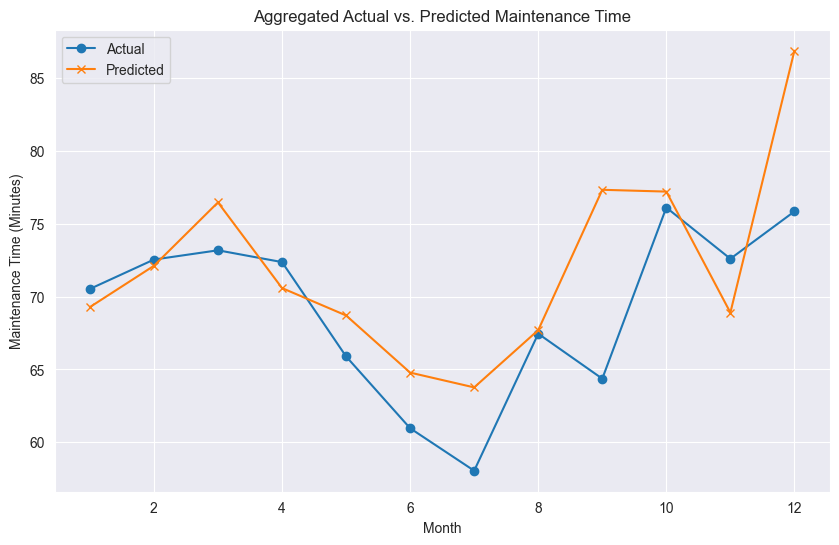

In [38]:
sm_df = sm_df[sm_df['PRODUCTION_LOCATION']=='COTA']
sm_df = sm_df[sm_df['EXECUTION_START_DATE'] >= '2022-01-01']

sm_df["EXECUTION_START_DATE"] = pd.to_datetime(sm_df["EXECUTION_START_DATE"])
sm_df["EXECUTION_FINISH_DATE"] = pd.to_datetime(sm_df["EXECUTION_FINISH_DATE"])
sm_df["DURATION"] = (sm_df["EXECUTION_FINISH_DATE"] - sm_df["EXECUTION_START_DATE"]).dt.total_seconds() / 60
sm_df["START_YEAR"] = sm_df["EXECUTION_START_DATE"].dt.year
sm_df["START_MONTH"] = sm_df["EXECUTION_START_DATE"].dt.month

X = sm_df[["EQUIPMENT_ID", "DURATION", "START_YEAR", "START_MONTH"]]
y = sm_df["ACTUAL_WORK_IN_MINUTES"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=32)

# XGBoost model
model = xgb.XGBRegressor(objective="reg:squarederror", 
                         learning_rate=0.1,
                         max_depth=5,
                         n_estimators=5000, 
                         random_state=63)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)


print(f"RMSE: {rmse:.2f} Minutes")
# Business context is minutes
print(f"MAE: {mae:.2f} Minutes")

X_test["ACTUAL_WORK_IN_MINUTES"] = y_test
X_test["PREDICTED_WORK_IN_MINUTES"] = y_pred
aggregated_data = X_test.groupby("START_MONTH").mean()

# Aggregated data
plt.figure(figsize=(10, 6))
plt.plot(aggregated_data.index, aggregated_data["ACTUAL_WORK_IN_MINUTES"], label="Actual", marker="o")
plt.plot(aggregated_data.index, aggregated_data["PREDICTED_WORK_IN_MINUTES"], label="Predicted", marker="x")
plt.title("Aggregated Actual vs. Predicted Maintenance Time")
plt.xlabel("Month")
plt.ylabel("Maintenance Time (Minutes)")
plt.legend()
plt.grid(True)
plt.show()

This shows the time series plot of the predictions of time spent on maintenance for COTA location